# Previsões de Séries Temporais

In [1]:
#importando bibliotecas essenciais
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

C:\Users\Rodrigo\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Rodrigo\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\Rodrigo\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# Download da série mensal do IBOVESPA
import quandl
data = quandl.get("BCB/7845", trim_start="2009-01-01")
data.head()

,Value
Date,
2009-01-31,39300.0
2009-02-28,38183.0
2009-03-31,40926.0
2009-04-30,47289.0
2009-05-31,53197.0


In [3]:
# Renomear a série
data.columns = ['Close']
data.shape

(128, 1)

Seperando a base em treino e teste

In [4]:
meses = 26
treino = data.iloc[:-meses,0:1].copy()
teste = data.iloc[-meses:,0:1].copy()

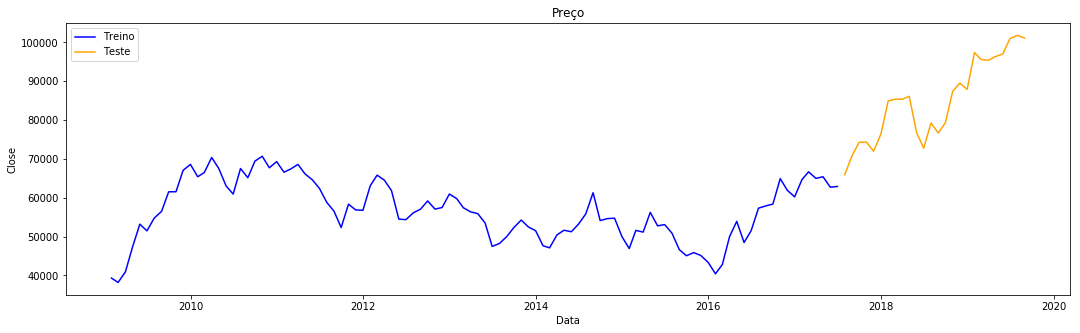

In [5]:
plt.figure(figsize=(18,5))
plt.title('Preço')
plt.plot(treino['Close'], color='b')
plt.plot(teste['Close'], color='orange')
plt.legend(['Treino','Teste'])
plt.xlabel('Data')
plt.ylabel('Close')
plt.show()

A partir de agora só iremos usar a base de treino para fazer os estudos, a base de teste será somente usada para validar as previsões que iremos fazer.

Toda série temporal pode ser decomposta em 3 partes: tendência, sazonalidade e resíduo, abaixo a separação dessas partes:

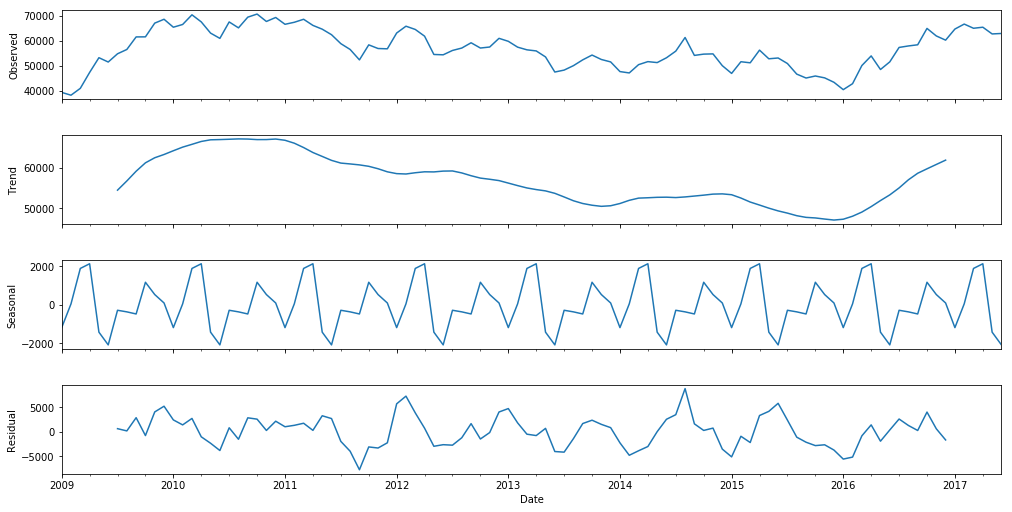

In [6]:
#gráfico mensal com ciclos que se repetem a cada 12 meses (1 ano)
season = seasonal_decompose(treino, freq=12)
fig = season.plot();
fig.set_size_inches(16,8)

Como podemos ver a série tem uma tendência de alta, com picos entre o final e inicio de anos.

### Transformando a série em estacionária

#### Diferenciação

A diferenciação é usada para remover os sinais de tendências e reduzir a variância, ela simplesmente é a diferença do valor do período T com o valor do período anterior T-1.

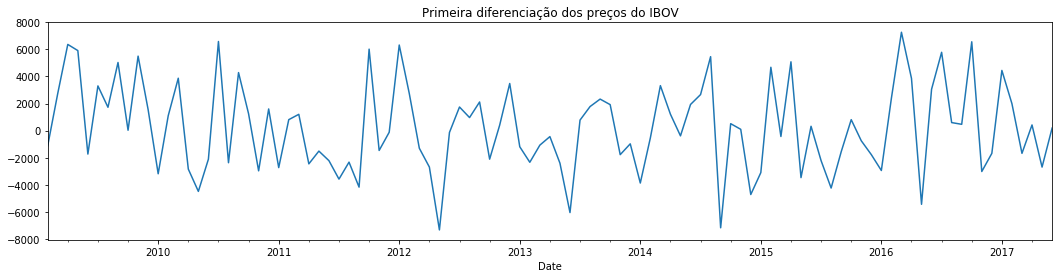

Mostrando as 10 primeiras diferenciações
Date
2009-02-28   -1117.0
2009-03-31    2743.0
2009-04-30    6363.0
2009-05-31    5908.0
2009-06-30   -1731.0
2009-07-31    3300.0
2009-08-31    1723.0
2009-09-30    5029.0
2009-10-31      28.0
2009-11-30    5498.0
Name: Close, dtype: float64


In [7]:
treino.loc[:,'Close'].diff().dropna().plot(figsize=(18,4), title='Primeira diferenciação dos preços do IBOV')
plt.show()
print('Mostrando as 10 primeiras diferenciações')
print(treino['Close'].diff().dropna().head(10))

In [8]:
treino['dif1'] = treino.loc[:,'Close'].diff().dropna()
treino = treino.dropna(inplace=False)

In [9]:
teste['dif1'] = teste.loc[:,'Close'].diff().dropna()
teste = teste.dropna(inplace=False)

In [10]:
#criando uma função para plotar o gráfico e mostrar o resultado do teste:
def adfuller_test(serie, figsize=(18,4), plot=True, title=""):
    if plot:
        serie.plot(figsize=figsize, title=title)
        plt.show()
    #Teste de Dickey Fuller sobre a primeira diferenciação
    adf = adfuller(serie)
    output = pd.Series(adf[0:4], index=['Teste Estatistico Dickey Fuller','Valor-P',
                                          'Lags Usados','Número de observações usadas'])
    output = round(output,4)
    
    for key, value in adf[4].items():
        output["Valores Críticos (%s)"%key] = value.round(4) 
    return output

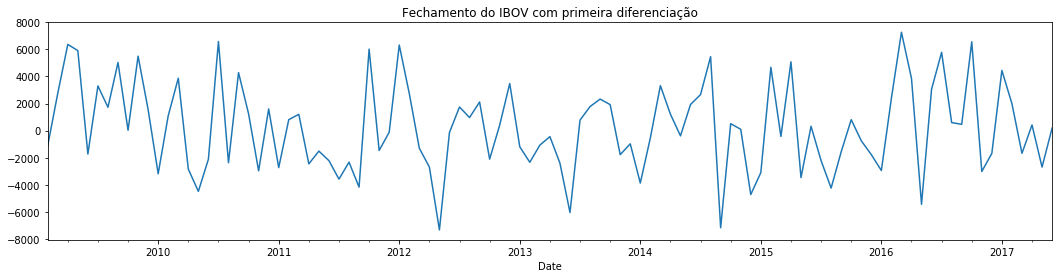

Teste Estatistico Dickey Fuller    -7.5837
Valor-P                             0.0000
Lags Usados                         1.0000
Número de observações usadas       99.0000
Valores Críticos (1%)              -3.4982
Valores Críticos (5%)              -2.8912
Valores Críticos (10%)             -2.5826
dtype: float64

In [11]:
adfuller_test(treino['dif1'], title='Fechamento do IBOV com primeira diferenciação')

Neste caso confirmamos que a série está estácionária, o valor P está zerado e se formos comparar, o valor do teste estatístico está muito abaixo dos valores críticos.

### À procura de lags correlacionados

Para ter previsibilidade uma série com uma única variável deve ser auto correlacionada, ou seja, o período atual deve ter explicação com base em um período anterior (lag).

Como esta série de preços tem períodos mensais, 1 ano tem 12 meses, vamos usar a função de auto correlação para um período de 12 lags para verificar correlações do período atual com estes lags.

Uma outra função extremamente importante é a função de auto correlação parcial, onde o efeito do lag anterior sobre o período atual é removido e só resta o efeito do lag analisado sobre o período atual, exemplo: a auto correlação parcial do quarto lag irá remover o efeito do primeiro, segundo e terceiro lag.

A série sem diferenciação não é estacionária, iremos plotar agora essas duas funções com a série com uma diferenciação:

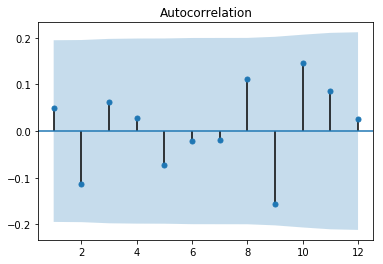

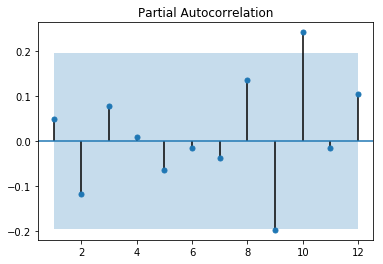

In [12]:
plot_acf(treino['dif1'], lags=12, zero=False);
plot_pacf(treino['dif1'], lags=12, zero=False);

O gráfico de auto correlação mostra que a série tem um efeito sazonal com correlação negativa ao redor do oitavo mês e uma correlação positiva ao redor do décimo mês.

Um detalhe extremamente importante sobre encontrar lags correlacionados para criar previsões é que é importante que haja uma razão para que esta correlação exista, pois caso não haja alguma razão lógica é possível que seja só o acaso ou que a parte que está sendo analisada apresentou esta correlação, podendo mudar ao analisar outra parte da série.

## Métricas de Avaliação

Para analisar se as previsões estão com os valores próximos dos dados reais deve-se fazer a medição do erro, o erro (ou resíduo) neste caso é basicamente 

<font size="2"> $ Y_{REAL} −Y_{PREVISÃO} $ </font>

Avalia-se o erro nos dados de treino para verificar se o modelo tem boa assertividade, e valida-se o modelo verificando o erro nos dados de teste (dados que não foram "vistos" pelo modelo).

#### Viés - Mean Forecast Error

O Viés nada mais é do que a média dos erros da série avaliada, os valores podem ser positivos ou negativos. Essa métrica sugere que o modelo tende a fazer previsões acima do real (erros negativos) ou abaixo do real (erros positivos).

#### MAE - Mean Absolute Error 

Essa métrica é muito semelhante ao erro médio da previsão mencionado acima, a única diferença é o erro com valor negativo, ou seja, a previsão com valor maior que o número real, é transformado em positivo e posteriormente a média é calculada.

#### MSE - Mean Squared Error

Essa métrica coloca mais peso nos erros maiores, pois cada valor individual do erro é elevado ao quadrado e posteriormente a média desses valores é calculada. Assim, essa métrica é muito sensível à outliers e coloca bastante peso nas previsões com erros mais significativos.

Diferente do MAE e MFE, os valores do MSE estão em unidades quadráticas e não na unidade do modelo.

#### RMSE - Root Mean Squared Error 

Essa métrica é simplesmente a raiz quadrada do MSE, onde o erro volta a ter a unidade de medida do modelo (R$/m3), ela é muito usada em séries temporais porque é mais sensível à erros maiores devido ao processo de elevação ao quadrado que a originou.

#### MAPE - Mean Absolute Percentage Error 

Essa é outra métrica interessante de ser usada, geralmente usada em relatórios gerenciais, pois o erro é medido em termos percentuais e pode-se comparar o erro percentual do modelo de um produto X com o erro percentual de um produto Y.

O cálculo dessa métrica pega o valor absoluto do erro dividido pelo preço real e posteriormente é calculada a média

### Checando os valores residuais

Criar o modelo e verificar o valor do seu resíduo de acordo com a métrica escolhida não é suficiente, é necessário analisar também o próprio resíduo, pois há casos em que o modelo não consegue capturar as informações necessárias para se fazer uma boa previsão resultando em um resíduo com "informações na mesa".

Para isso temos:

- Valores reais vs previstos (sequencial);
- Resíduo vs valores previstos (dispersão):
O ideal é que o erro esteja distribuído linearmente ao longo da sequência da previsão.
- QQ plot do resíduo (dispersão):
Mostra o resíduo distribuído teoricamente, seguindo uma distribuição gaussiana, em comparação como ele realmente ficou.
- Autocorrelação do resíduo (sequencial):
Onde não deve haver valores que saiam da margem de confiança, ou o modelo está deixando informação na mesa.

Abaixo temos uma função para avaliar o erro dos dados de treino e teste com várias métricas de avaliação:

In [13]:
# Vamos criar uma função com todos os erros consolidados:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error

def erros(orig, prev, nome_col='', nome_indice=''):
    
    vies = np.mean(orig - prev)
    mse = mean_squared_error(orig, prev)
    rmse = sqrt(mean_squared_error(orig, prev))
    mae = mean_absolute_error(orig, prev)
    mape = np.mean(np.abs((orig - prev) / orig)) * 100
    
    grupo_erro = [vies, mse, rmse, mae, mape]
    serie = pd.DataFrame(grupo_erro, index=['VIÉS','MSE','RMSE','MAE', 'MAPE'], columns=[nome_col])
    serie.index.name = nome_indice
    
    return serie

Abaixo temos uma função para plotar gráficos para checar os valores residuais:

In [14]:
def plot_erro(dados, figsize=(18,8)):
    
    # Criando a coluna do erro
    dados['Erro'] = dados.iloc[:,0] - dados.iloc[:,1]
    
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    #Plotando os valores reais e previstos
    ax1.plot(dados.iloc[:,0:2])
    ax1.legend(['Real','Prev'])
    ax1.set_title('Valores Reais vs Previstos')
    
    # Erro vs Valores previstos
    ax2.scatter(dados.iloc[:,1], dados.iloc[:,2])
    ax2.set_xlabel('Valores Previstos')
    ax2.set_ylabel('Resíduo')
    ax2.set_title('Resíduo vs Valores Previstos')
    
    ## QQ Plot do erro
    sm.graphics.qqplot(dados.iloc[:,2], line='r', ax=ax3)
    
    # Gráfico de autocorrelação do Erro
    plot_acf(dados.iloc[:,2], lags=12,zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

## Modelos de Previsão

#### Auto Regressivo  

Um modelo auto regressivo é basicamente uma regressão linear com lags significativamente correlacionados, utilizamos esses lags para treinar o modelo.

Abaixo está o gráfico de autocorrelação e autocorrelação parcial da série de treino:

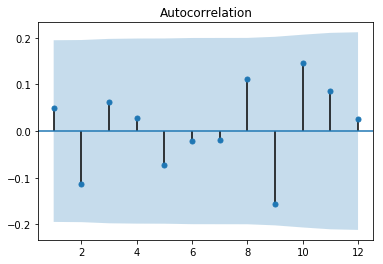

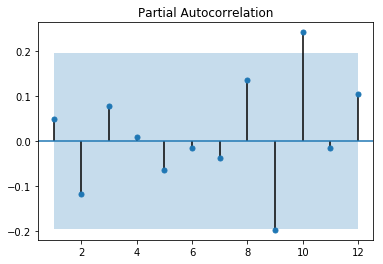

In [15]:
plot_acf(treino['dif1'], lags=12, zero=False);
plot_pacf(treino['dif1'], lags=12, zero=False);

Abaixo vamos criar o modelo com base nos dados de treino e após obter os coeficientes do modelo, iremos multiplicá-los pelos valores que forem sendo realizados pelos dados do teste:

#######################################    MODELO ARMA NA BASE DE TREINO   ###########################################


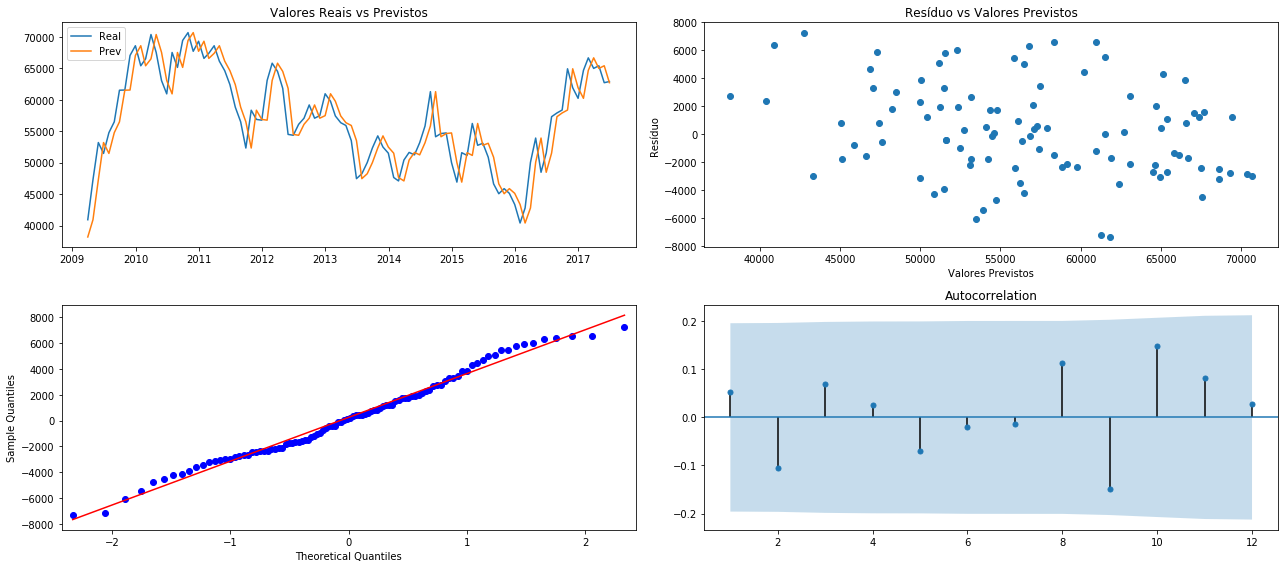

,Auto Regr.
Base Treino,
VIÉS,1.961422e+00
MSE,1.050077e+07
RMSE,3.240490e+03
MAE,2.655225e+03
MAPE,1.264889e+02


In [57]:
ar_treino = treino[['dif1']]
ar_treino.columns = ['Real']

#criando o modelo:
from statsmodels.tsa.arima_model import ARMA
modelo = ARMA(ar_treino['Real'], order=[2,0]).fit()
ar_treino['Previsão'] = modelo.predict(start=0, end=len(ar_treino)-1)

# Checando o erro do modelo auto regressivo
erro_treino = erros(ar_treino['Real'], 
                         ar_treino['Previsão'], 
                         nome_col='Auto Regr.', 
                         nome_indice='Base Treino')

print('#######################################    MODELO ARMA NA BASE DE TREINO   ###########################################')
plot_erro(simples_treino)
erro_treino

O gráfico QQ mostra que há alguns outliers nos resíduos, além disso há autocorrelação significativa no oitavo, nono e décimo lag, os quais poderiam ser usados para melhorar o modelo.
Agora fazer a previsão nos dados de teste.

#######################################    MODELO ARMA NA BASE DE TESTE   ###########################################


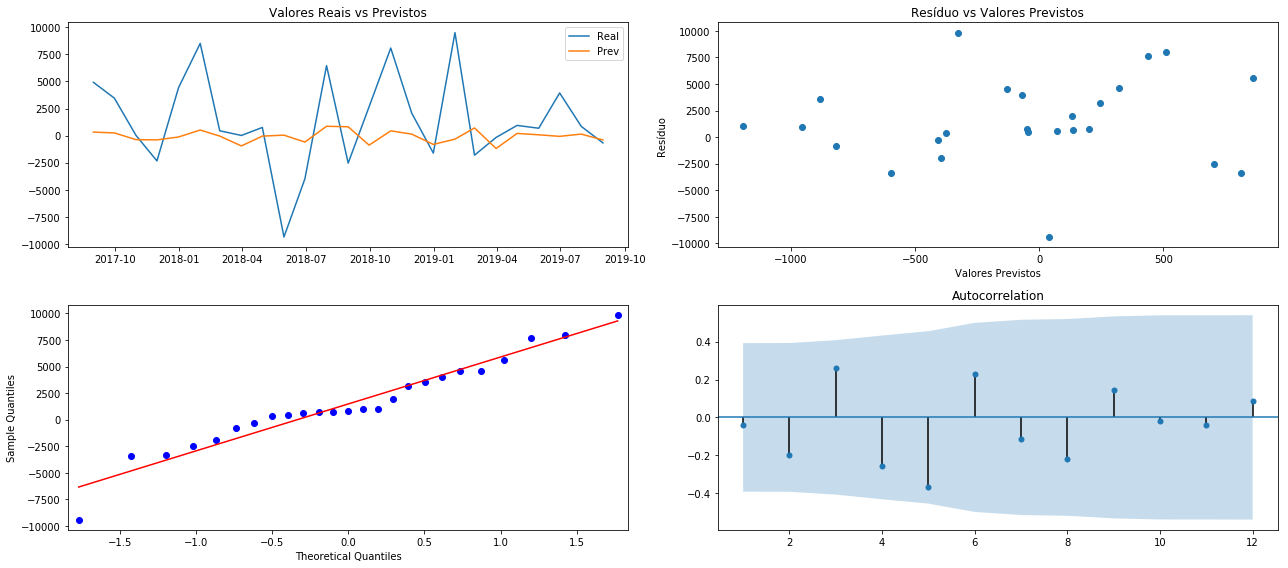

,Auto Regr.
Base Teste,
VIÉS,1.479662e+03
MSE,1.846012e+07
RMSE,4.296524e+03
MAE,3.213741e+03
MAPE,5.348363e+02


In [58]:
ar_teste = teste[['dif1']]
ar_teste.columns = ['Real']

#validando os dados usando os coeficientes do modelo treinado:
coef_l1, coef_l2 = modelo.arparams
hist = [ar_treino.iloc[i,0] for i in range(len(ar_treino))]
prev = []
for t in range(len(ar_teste)):
    yhat = (hist[-1] * coef_l1) + (hist[-2] * coef_l2)
    obs = ar_teste.iloc[t,0]
    prev.append(yhat)
    hist.append(obs)
    
ar_teste['Previsão'] = prev

#plotando o gráfico de teste


print('#######################################    MODELO ARMA NA BASE DE TESTE   ###########################################')
plot_erro(ar_teste)

# Checando o erro do modelo auto regressivo
erro_teste = erros(ar_teste['Real'], 
                        ar_teste['Previsão'], 
                        nome_col='Auto Regr.',
                       nome_indice='Base Teste')

erro_teste

Nota-se que na validação dos dados o gráfico das previsões não se ajustou aos valores reais, isso abre espaço para testarmos mais modelos. É claro que podemos tentar melhorar este modelo, pode-se aplicar várias transformações, além disso pode-se adicionar variáveis externas como fonte de previsão, mas a principio vamos testar outros modelos. 

## Média móvel simples

A média móvel é uma média que é calculada por um período determinado (3 meses por exemplo) e vai se movendo e sendo calculada sempre usando este período determinado, neste caso estaremos usando sempre a média os últimos 3 meses para prever o valor do mês seguinte.

In [49]:
mm_treino = treino[['Close']]
mm_treino.columns = ['Real']
mm_treino['Previsão'] = mm_treino.rolling(3).mean()
mm_treino.dropna(inplace=True)

# Checando o erro do modelo de treino de médias móveis
erro_treino['Média Móvel'] = erros(mm_treino['Real'], mm_treino['Previsão'])
erro_treino.round(4)

,Auto Regr.,Média Móvel
Base Treino,,
VIÉS,1.961400e+00,2.305522e+02
MSE,1.050077e+07,6.313664e+06
RMSE,3.240490e+03,2.512701e+03
MAE,2.655225e+03,2.056808e+03
MAPE,1.264889e+02,3.673700e+00


Validação na base de testes

###########################    MODELO DE MÉDIA MÓVEL DE 3 MESES NA BASE DE TESTE   ###############################


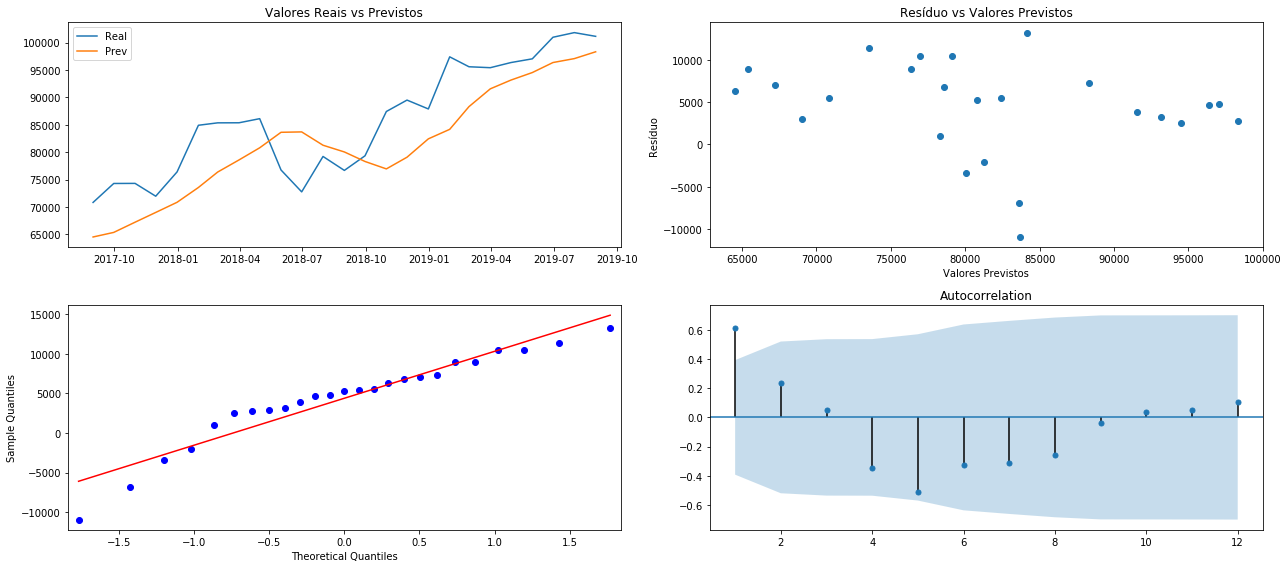

,Auto Regr.,Média Móvel
Base Teste,,
VIÉS,1.479662e+03,4.384432e+03
MSE,1.846012e+07,4.939891e+07
RMSE,4.296524e+03,7.028436e+03
MAE,3.213741e+03,6.242800e+03
MAPE,5.348363e+02,7.401747e+00


In [60]:
mm_teste = teste[['Close']]
mm_teste.columns = ['Real']

# calculo para média móvel de 3 meses para cada interação:
hist = [mm_treino.iloc[i,0] for i in range(len(mm_treino))]
prev = []
for t in range(len(mm_teste)):
    yhat = np.mean(hist[-5:])
    obs = mm_teste.iloc[t,0]
    prev.append(yhat)
    hist.append(obs)
    
mm_teste['Previsão'] = prev





#plotando o gráfico de teste
print('###########################    MODELO DE MÉDIA MÓVEL DE 3 MESES NA BASE DE TESTE   ###############################')
plot_erro(mm_teste)

# Checando o erro do modelo de teste de médias móveis
erro_teste['Média Móvel'] = erros(mm_teste['Real'], mm_teste['Previsão'])
erro_teste

É possível identificar que o erro está com uma variância muito alta em relação aos valores previstos. Além disso, não foi possível obter resultados satisfatórios quando comparado ao Auto Regressivo. 

## Modelo Simples

Uma metodologia simples de se fazer previsões é usar o valor do período anterior, na maioria das vezes funciona bem quando o intuito é prever período curto, contudo quando queremos prever vários períodos os erros tendem a aumentar. Vale ressaltar que muitas das vezes usam essa abordagem como baseline para tentar melhorar com modelos mais complexos.

In [51]:
#Criando variável de treino 
simples_treino = treino[['Close']]
simples_treino.columns = ['Real']
simples_treino['Previsão'] = simples_treino['Real'].shift()
simples_treino.dropna(inplace=True)

# Checando o erro do modelo 
erro_treino['Modelo Simples'] = erros(simples_treino['Real'], simples_treino['Previsão'])
erro_treino.round(4)

,Auto Regr.,Média Móvel,Modelo Simples
Base Treino,,,
VIÉS,1.961400e+00,2.305522e+02,2.471600e+02
MSE,1.050077e+07,6.313664e+06,1.081886e+07
RMSE,3.240490e+03,2.512701e+03,3.289204e+03
MAE,2.655225e+03,2.056808e+03,2.682300e+03
MAPE,1.264889e+02,3.673700e+00,4.785100e+00


######################################    MODELO SIMPLES NA BASE DE TESTE   ###########################################


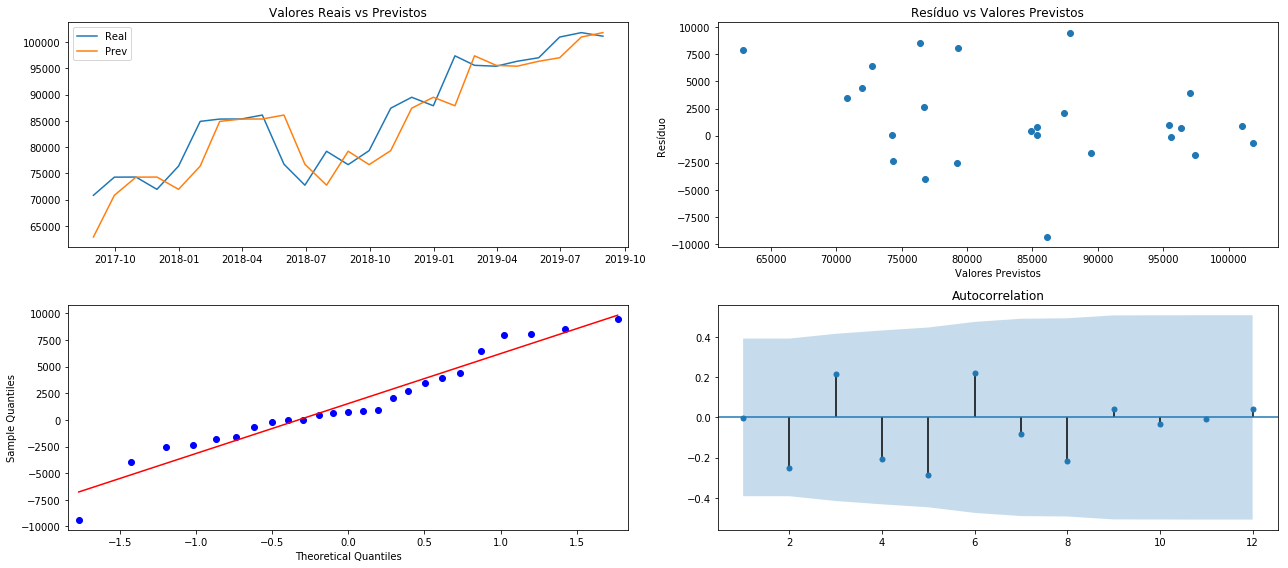

,Auto Regr.,Média Móvel,Modelo Simples
Base Teste,,,
VIÉS,1.479662e+03,4.384432e+03,1.529400e+03
MSE,1.846012e+07,4.939891e+07,2.064004e+07
RMSE,4.296524e+03,7.028436e+03,4.543132e+03
MAE,3.213741e+03,6.242800e+03,3.330040e+03
MAPE,5.348363e+02,7.401747e+00,4.046921e+00


In [63]:
simples_teste = teste[['Close']]
simples_teste.columns = ['Real']

#adicionando o primeiro valor da Previsão com o último dado Real do teste
hist = [simples_treino.iloc[i,0] for i in range(len(simples_treino))]
prev = []
for t in range(len(simples_teste)):
    yhat = hist[-1]
    obs = simples_teste.iloc[t,0]
    prev.append(yhat)
    hist.append(obs)

simples_teste['Previsão'] = prev


print('######################################    MODELO SIMPLES NA BASE DE TESTE   ###########################################')
plot_erro(simples_teste)

# Checando o erro do modelo 
erro_teste['Modelo Simples'] = erros(simples_teste['Real'], simples_teste['Previsão'])


erro_teste

No gráfico de valores reais comparados aos previstos é notável que há uma melhoria nos resultados quando comparamos com os outros modelos testados.
A ideia deste estudo foi apresentar conceitos de analise de séries temporais, desde checar estacionariedade, transformar os dados, criar modelo, validar na base de testes, checar o erro. Esse são passos essenciais para o desenvolvimento de modelos para previsões de séries temporais, esses pontos devem ser analisados para podermos extrair o máximo de informação possível.